In [288]:
import pandas as pd
import numpy as np
import warnings
import utils

OAK = 'FOAK'
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Load batched NREL data from MAX

In [289]:
nrel_data = pd.read_excel('./input_data/direct_heat_maxv/facs_batched.xlsx')
nrel_data.drop(columns=['Unnamed: 0'], inplace=True)
# Convert total from TJ to MJ 

nrel_data.drop(columns=['Total'], inplace=True)
nrel_data.columns

Index(['CITY', 'COUNTY', 'COUNTY_FIPS', 'Coal', 'Diesel', 'END_USE',
       'FACILITY_ID', 'FINAL_NAICS_CODE', 'FUEL_TYPE', 'FUEL_TYPE_BLEND',
       'FUEL_TYPE_OTHER', 'LPG_NGL', 'MECS_NAICS', 'Natural_gas', 'Other',
       'Process_byp', 'Pulp_Paper', 'REPORTING_YEAR', 'Residual_fuel_oil',
       'STATE', 'Temp_degC', 'UNIT_NAME', 'UNIT_TYPE', 'for_EU_sum',
       'Temp_Band', 'Biogenic', 'MMTCO2E', 'Batch_Temp_degC',
       'Highest_Temp_served_degC', 'Emissions_mmtco2/y', 'Heat_demand_MWh/hr',
       'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod',
       'Helper'],
      dtype='object')

In [290]:
len(nrel_data)

1764

In [291]:
# Load results from MAX
max_results = pd.read_csv('./input_data/direct_heat_maxv/Full_Spread_SMRs.csv')
max_results.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
max_results.columns

Index(['CITY', 'COUNTY', 'COUNTY_FIPS', 'Coal', 'Diesel', 'END_USE',
       'FACILITY_ID', 'FINAL_NAICS_CODE', 'FUEL_TYPE', 'FUEL_TYPE_BLEND',
       'FUEL_TYPE_OTHER', 'LPG_NGL', 'MECS_NAICS', 'Natural_gas', 'Other',
       'Process_byp', 'Pulp_Paper', 'REPORTING_YEAR', 'Residual_fuel_oil',
       'STATE', 'Temp_degC', 'Total', 'UNIT_NAME', 'UNIT_TYPE', 'for_EU_sum',
       'Temp_Band', 'Biogenic', 'MMTCO2E', 'Batch_Temp_degC',
       'Highest_Temp_served_degC', 'Emissions_mmtco2/y', 'Heat_demand_MWh/hr',
       'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod',
       'Helper', 'Reactor', 'Power in MWt', 'Thermal Efficiency',
       'Outlet Temp (C)', 'CAPEX $/MWe_foak', 'FOPEX $/MWe-y_foak',
       'VOM in $/MWh-e_foak', 'CAPEX $/MWe', 'FOPEX $/MWe-y', 'VOM in $/MWh-e',
       'Life (y)', 'Modules', 'SMR_Capacity', 'SMR_Capacity_e',
       'Surplus_Capacity', 'Surplus_Capacity_e', 'CRF', 'Total_CAPEX_FOAK',
       'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK', 

In [292]:
len(max_results)

7834

# Compute equivalent H2 demand

In [293]:
def compute_h2_demand(heat, temp, AHF_coeffs = [0, -0.00038, .90556]):
  """Computes the equivalent hydrogen demand to produce heat 
  Args:
    - heat (float): heat demand in MW
    - temp (float): temperature in degree Celsius
    - AHF_coeffs (list(float)): coefficients for Available Heat Fraction calculation
  Returns:
    - h2_demand (float): hydrogen demand in kg/h
  """
  AHF = AHF_coeffs[0]*(int(temp)^2) + AHF_coeffs[1]*int(temp) + AHF_coeffs[2]
  h2_demand = heat*utils.mwh_to_mj/(utils.h2_hhv*AHF)
  return h2_demand

In [294]:
nrel_data['Total H2 Dem. (kg/h)'] = nrel_data.apply(lambda x : compute_h2_demand(x['Heat_demand_MWh/hr'], x['Batch_Temp_degC']), axis=1)
nrel_data['Remaining H2 Dem. (kg/h)'] = nrel_data.apply(lambda x:compute_h2_demand(x['Remaining_Heat_MW'], x['Remaining_temp_degC']), axis=1)

In [295]:
nrel_data.columns

Index(['CITY', 'COUNTY', 'COUNTY_FIPS', 'Coal', 'Diesel', 'END_USE',
       'FACILITY_ID', 'FINAL_NAICS_CODE', 'FUEL_TYPE', 'FUEL_TYPE_BLEND',
       'FUEL_TYPE_OTHER', 'LPG_NGL', 'MECS_NAICS', 'Natural_gas', 'Other',
       'Process_byp', 'Pulp_Paper', 'REPORTING_YEAR', 'Residual_fuel_oil',
       'STATE', 'Temp_degC', 'UNIT_NAME', 'UNIT_TYPE', 'for_EU_sum',
       'Temp_Band', 'Biogenic', 'MMTCO2E', 'Batch_Temp_degC',
       'Highest_Temp_served_degC', 'Emissions_mmtco2/y', 'Heat_demand_MWh/hr',
       'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod',
       'Helper', 'Total H2 Dem. (kg/h)', 'Remaining H2 Dem. (kg/h)'],
      dtype='object')

In [296]:
ng_df = nrel_data[['FACILITY_ID','STATE', 'Temp_degC', 'Batch_Temp_degC', 'Highest_Temp_served_degC', 'Emissions_mmtco2/y',\
                    'Heat_demand_MWh/hr', 'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod',\
                    'Total H2 Dem. (kg/h)', 'Remaining H2 Dem. (kg/h)']]
ng_df

,FACILITY_ID,STATE,Temp_degC,Batch_Temp_degC,Highest_Temp_served_degC,Emissions_mmtco2/y,Heat_demand_MWh/hr,Remaining_Heat_MW,Remaining_temp_degC,Temp_Req,NG_HLMP_mod,Total H2 Dem. (kg/h),Remaining H2 Dem. (kg/h)
0,1000588,IN,180,180.0,180,0.053375,36.981306,245.244448,1100.0,301,4.135126,1120.869604,12762.990238
1,1007177,OH,180,180.0,180,0.059347,41.119048,272.684210,1100.0,301,4.135126,1246.280783,14191.007958
2,1003962,IN,180,180.0,180,0.104661,72.515650,480.893261,1100.0,301,4.135126,2197.883145,25026.605266
3,1000274,OH,180,180.0,180,0.184366,127.740282,847.119764,1100.0,301,4.135126,3871.691292,44085.733073
4,1003403,MI,180,180.0,180,0.039142,27.119693,179.846384,1100.0,301,4.135126,821.973124,9359.549870
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759,1002443,IA,450,450.0,450,0.161346,111.790635,0.000000,0.0,629,4.710265,3859.533901,0.000000
1760,1002356,IL,450,450.0,450,0.170369,118.041929,0.000000,0.0,629,4.712701,4077.465961,0.000000
1761,1005683,NE,450,450.0,450,0.065488,45.374382,0.000000,0.0,629,4.712701,1567.345603,0.000000
1762,1002627,IA,450,450.0,450,0.178448,123.639492,0.000000,0.0,629,4.712701,4270.819904,0.000000


# Analyze costs and revenues with each ANR design for ANR-H2 pathway

## Import ANR-H2 input parameters

In [297]:
h2_techs = pd.read_excel('./h2_tech.xlsx', sheet_name = 'Summary')
h2_techs.rename(columns={'CAPEX ($/MWe)':'H2 CAPEX ($/MWe)',
                 'FOM ($/MWe-year)':'H2 FOM ($/MWe-year)',
                 'VOM ($/MWhe)':'H2 VOM ($/MWhe)'}, inplace=True)

In [298]:
anrs = pd.read_excel('./ANRs.xlsx', sheet_name=OAK)
anrs.rename(columns={'CAPEX $/MWe':'ANR CAPEX ($/MWe)',
                 'FOPEX $/MWe-y':'ANR FOM ($/MWe-year)',
                 'VOM in $/MWh-e':'ANR VOM ($/MWhe)', 
                 'Startupfixedcost in $':'Start Cost ($)'}, inplace=True)
anrs

,Reactor,Type,Power in MWe,Power in MWt,MSL in MWe,Thermal Efficiency,Thermal transfer efficiency,MDT in hours,Ramp Rate (fraction of capacity/hr),Ramp Rate (MW/hr),Outlet Temp (C),ANR CAPEX ($/MWe),ANR FOM ($/MWe-year),Max Modules,ANR VOM ($/MWhe),Start Cost ($),Life (y)
0,iPWR,PWR,77.0,250,15.4,0.31,1.000,20,0.4,24.0,302,5535000,115000,12,9.75,38500,60
1,HTGR,HTGR,164.0,350,32.8,0.47,0.897,20,6.0,984.0,950,7500000,164000,4,13.00,82000,60
2,PBR-HTGR,HTGR,80.0,200,32.0,0.40,0.751,20,2.4,48.0,750,4569000,100000,12,13.00,40000,60
3,iMSR,MSR,141.0,300,28.2,0.47,0.936,20,0.6,84.6,700,4091000,85000,12,11.50,70500,60
4,Micro,HTGR,6.7,20,2.7,0.33,0.897,20,6.0,24.0,630,10902000,264000,12,0.00,3350,20


In [299]:
techs = pd.merge(h2_techs, anrs, left_on='ANR', right_on='Reactor')
techs

,Technology,ANR,Carbon intensity ANR (kgCO2eq/MWhe),H2Cap (MWe),H2Cap (kgh2/h),H2ElecCons (MWhe/kgh2),H2HeatCons (MWht/kgh2),Eq tot H2ElecCons (MWhe/kgh2),Eq tot H2HeatCons (MWht/kgh2),H2 CAPEX ($/MWe),...,MDT in hours,Ramp Rate (fraction of capacity/hr),Ramp Rate (MW/hr),Outlet Temp (C),ANR CAPEX ($/MWe),ANR FOM ($/MWe-year),Max Modules,ANR VOM ($/MWhe),Start Cost ($),Life (y)_y
0,HTSE,iPWR,12,1.3754,41.666667,0.03048,0.00816,0.033010,0.106483,646487,...,20,0.4,24.0,302,5535000,115000,12,9.75,38500,60
1,PEM,iPWR,12,1.0000,9.900990,0.10100,0.00000,0.101000,0.325806,1500000,...,20,0.4,24.0,302,5535000,115000,12,9.75,38500,60
2,Alkaline,iPWR,12,2.0000,37.037037,0.05400,0.00000,0.054000,0.174194,743865,...,20,0.4,24.0,302,5535000,115000,12,9.75,38500,60
3,HTSE,HTGR,12,0.9510,41.666667,0.00816,0.03120,0.022824,0.048562,646487,...,20,6.0,984.0,950,7500000,164000,4,13.00,82000,60
4,PEM,HTGR,12,1.0000,9.900990,0.10100,0.00000,0.101000,0.214894,1500000,...,20,6.0,984.0,950,7500000,164000,4,13.00,82000,60
5,Alkaline,HTGR,12,2.0000,37.037037,0.05400,0.00000,0.054000,0.114894,743865,...,20,6.0,984.0,950,7500000,164000,4,13.00,82000,60
6,HTSE,PBR-HTGR,12,0.8600,41.666667,0.00816,0.03120,0.020640,0.051600,646487,...,20,2.4,48.0,750,4569000,100000,12,13.00,40000,60
7,PEM,PBR-HTGR,12,1.0000,9.900990,0.10100,0.00000,0.101000,0.252500,1500000,...,20,2.4,48.0,750,4569000,100000,12,13.00,40000,60
8,Alkaline,PBR-HTGR,12,2.0000,37.037037,0.05400,0.00000,0.054000,0.135000,743865,...,20,2.4,48.0,750,4569000,100000,12,13.00,40000,60
9,HTSE,iMSR,12,0.8922,41.666667,0.00720,0.03024,0.021413,0.045559,646487,...,20,0.6,84.6,700,4091000,85000,12,11.50,70500,60


## Combine demand data and ANR-H2 parameters

In [300]:
ff = ng_df.merge(techs, how='cross') # full facilities

ff.columns



Index(['FACILITY_ID', 'STATE', 'Temp_degC', 'Batch_Temp_degC',
       'Highest_Temp_served_degC', 'Emissions_mmtco2/y', 'Heat_demand_MWh/hr',
       'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod',
       'Total H2 Dem. (kg/h)', 'Remaining H2 Dem. (kg/h)', 'Technology', 'ANR',
       'Carbon intensity ANR (kgCO2eq/MWhe)', 'H2Cap (MWe)', 'H2Cap (kgh2/h)',
       'H2ElecCons (MWhe/kgh2)', 'H2HeatCons (MWht/kgh2)',
       'Eq tot H2ElecCons (MWhe/kgh2)', 'Eq tot H2HeatCons (MWht/kgh2)',
       'H2 CAPEX ($/MWe)', 'H2 FOM ($/MWe-year)', 'H2 VOM ($/MWhe)',
       'Life (y)_x', 'ANR Th Eff', 'Carbon intensity (kgCO2eq/kgH2)',
       'Reactor', 'Type', 'Power in MWe', 'Power in MWt', 'MSL in MWe',
       'Thermal Efficiency', 'Thermal transfer efficiency', 'MDT in hours',
       'Ramp Rate (fraction of capacity/hr)', 'Ramp Rate (MW/hr)',
       'Outlet Temp (C)', 'ANR CAPEX ($/MWe)', 'ANR FOM ($/MWe-year)',
       'Max Modules', 'ANR VOM ($/MWhe)', 'Start Cost ($)', 'Lif

## Cashflows Calculations for ANR-H2 to serve total demand

In [301]:
import math
ff['H2 Modules_tot'] = ff.apply(lambda x: math.ceil(x['Total H2 Dem. (kg/h)']/x['H2Cap (kgh2/h)']), axis=1)
ff['Depl. H2 Cap. (kgh2/h)_tot'] = ff['H2 Modules_tot']*ff['H2Cap (kgh2/h)']
ff['Depl. H2 Cap. (MWe)_tot'] = ff['H2 Modules_tot']*ff['H2Cap (MWe)']
ff['ANR Modules_tot'] = ff.apply(lambda x: math.ceil(x['Depl. H2 Cap. (MWe)_tot']/x['Power in MWe']), axis=1)
ff['Depl. ANR Cap. (MWe)_tot'] = ff['ANR Modules_tot']*ff['Power in MWe']
ff['Depl. ANR Cap. (MWt)_tot'] = ff['ANR Modules_tot']*ff['Power in MWt']
ff['Surplus ANR Cap. (MWe)_tot'] = ff['Depl. ANR Cap. (MWe)_tot']-ff['Depl. H2 Cap. (MWe)_tot']
ff['Surplus ANR Cap. (MWt)_tot'] = ff['Surplus ANR Cap. (MWe)_tot']/ff['Thermal Efficiency']

In [302]:
# Compute costs in $/year
# Capital recovery factor
IR = utils.WACC
ff['ANR CRF'] = (IR/(1-((1+IR)**(-1*(ff['Life (y)_y'])))))
ff['H2 CRF'] = (IR/(1-((1+IR)**(-1*(ff['Life (y)_x'])))))

# ITC
itc_anr = utils.ITC_ANR
itc_h2 = utils.ITC_H2

## CAPEX
ff['Tot ANR CAPEX_tot'] = ff['Depl. ANR Cap. (MWe)_tot']*ff['ANR CAPEX ($/MWe)']
ff['Annual ANR CAPEX_tot'] = ff['Tot ANR CAPEX_tot']*ff['ANR CRF']*(1-itc_anr)
ff['Tot H2 CAPEX_tot'] = ff['Depl. H2 Cap. (MWe)_tot']*ff['H2 CAPEX ($/MWe)']
ff['Annual H2 CAPEX_tot'] = ff['Tot H2 CAPEX_tot']*ff['H2 CRF']*(1-itc_h2)
ff['Annual ANR-H2 CAPEX_tot'] = ff['Annual ANR CAPEX_tot']+ff['Annual H2 CAPEX_tot']

## FOM
ff['ANR FOM_tot'] = ff['Depl. ANR Cap. (MWe)_tot']*ff['ANR FOM ($/MWe-year)']
ff['H2 FOM_tot'] = ff['Depl. H2 Cap. (MWe)_tot']*ff['H2 FOM ($/MWe-year)']
ff['ANR-H2 FOM_tot'] = ff['ANR FOM_tot']+ff['H2 FOM_tot']

## VOM
ff['ANR VOM_tot'] =ff['Total H2 Dem. (kg/h)']*8760*ff['Eq tot H2ElecCons (MWhe/kgh2)']*ff['ANR VOM ($/MWhe)']
ff['H2 VOM_tot'] =ff['Total H2 Dem. (kg/h)']*8760*ff['H2 VOM ($/MWhe)']
ff['ANR-H2 VOM_tot'] = ff['ANR VOM_tot']+ff['H2 VOM_tot']

## Conversion costs
gf_crf = IR/ (1 - (1/(1+IR)**utils.GFLT) ) 
ff['Conversion_tot'] = utils.GFCAPEX*gf_crf*(1-itc_h2)*ff['Heat_demand_MWh/hr']


# Total cost
ff['ANR-H2 Total Cost ($/year)_tot'] = ff['Annual ANR-H2 CAPEX_tot'] + ff['ANR-H2 FOM_tot'] + ff['ANR-H2 VOM_tot'] +ff['Conversion_tot']


In [303]:
# Compute revenues in $/year
# Avoided NG costs
def compute_ng_multiplier(temp, AHF_coeffs=[0, -.00038, 0.90556]):
  # Available Heat Fraction
  AHF = AHF_coeffs[0]*(int(temp)**2)+ AHF_coeffs[1]*int(temp) + AHF_coeffs[2]
  multiplier = AHF/utils.mmbtu_to_mj
  return multiplier
ff['NG Mult (MMBtu/MJ)'] = ff.apply(lambda x: compute_ng_multiplier(x['Batch_Temp_degC']), axis=1) 
# Merge state-level prices
ng_prices = pd.read_excel('./input_data/eia_aeo_industrial_sector_ng_prices.xlsx', sheet_name='state_prices')
# 2024 prices
ng_prices = ng_prices[ng_prices.year == 2024]
ng_prices.rename(columns={'price 2020USD/MMBtu':'NG price ($/MMBtu)'}, inplace=True)
ff = ff.merge(ng_prices, left_on='STATE', right_on='state')
ff['Avoided NG Cost_tot'] = ff['NG price ($/MMBtu)']*ff['NG Mult (MMBtu/MJ)']*ff['Heat_demand_MWh/hr']*utils.mwh_to_mj*8760

# H2 PTC
ff['H2 PTC_tot'] = utils.h2_ptc*ff['Total H2 Dem. (kg/h)']*8760

In [304]:
ff['ANR-H2 Net Ann. Rev. ($/year)_tot'] = -ff['ANR-H2 Total Cost ($/year)_tot']+ff['H2 PTC_tot']+ff['Avoided NG Cost_tot']

In [305]:
ff.head(20)

,FACILITY_ID,STATE,Temp_degC,Batch_Temp_degC,Highest_Temp_served_degC,Emissions_mmtco2/y,Heat_demand_MWh/hr,Remaining_Heat_MW,Remaining_temp_degC,Temp_Req,...,H2 VOM_tot,ANR-H2 VOM_tot,ANR-H2 Total Cost ($/year)_tot,NG Mult (MMBtu/MJ),state,year,NG price ($/MMBtu),Avoided NG Cost_tot,H2 PTC_tot,ANR-H2 Net Ann. Rev. ($/year)_tot
0,1000588,IN,180,180.0,180,0.053375,36.981306,245.244448,1100.0,301,...,2.709994e+07,3.026006e+07,7.583618e+07,0.000793,IN,2024,5.119415,4.737404e+06,2.945645e+07,-4.164232e+07
1,1000588,IN,180,180.0,180,0.053375,36.981306,245.244448,1100.0,301,...,1.276446e+07,2.243354e+07,1.250415e+08,0.000793,IN,2024,5.119415,4.737404e+06,2.945645e+07,-9.084761e+07
2,1000588,IN,180,180.0,180,0.053375,36.981306,245.244448,1100.0,301,...,0.000000e+00,5.169608e+06,5.554336e+07,0.000793,IN,2024,5.119415,4.737404e+06,2.945645e+07,-2.134950e+07
3,1000588,IN,180,180.0,180,0.053375,36.981306,245.244448,1100.0,301,...,2.709994e+07,3.001330e+07,1.551691e+08,0.000793,IN,2024,5.119415,4.737404e+06,2.945645e+07,-1.209752e+08
4,1000588,IN,180,180.0,180,0.053375,36.981306,245.244448,1100.0,301,...,1.276446e+07,2.565657e+07,1.668698e+08,0.000793,IN,2024,5.119415,4.737404e+06,2.945645e+07,-1.326759e+08
5,1000588,IN,180,180.0,180,0.053375,36.981306,245.244448,1100.0,301,...,0.000000e+00,6.892810e+06,1.379313e+08,0.000793,IN,2024,5.119415,4.737404e+06,2.945645e+07,-1.037375e+08
6,1000588,IN,180,180.0,180,0.053375,36.981306,245.244448,1100.0,301,...,2.709994e+07,2.973452e+07,6.841073e+07,0.000793,IN,2024,5.119415,4.737404e+06,2.945645e+07,-3.421687e+07
7,1000588,IN,180,180.0,180,0.053375,36.981306,245.244448,1100.0,301,...,1.276446e+07,2.565657e+07,1.171002e+08,0.000793,IN,2024,5.119415,4.737404e+06,2.945645e+07,-8.290636e+07
8,1000588,IN,180,180.0,180,0.053375,36.981306,245.244448,1100.0,301,...,0.000000e+00,6.892810e+06,5.168442e+07,0.000793,IN,2024,5.119415,4.737404e+06,2.945645e+07,-1.749056e+07
9,1000588,IN,180,180.0,180,0.053375,36.981306,245.244448,1100.0,301,...,2.709994e+07,2.951779e+07,8.872439e+07,0.000793,IN,2024,5.119415,4.737404e+06,2.945645e+07,-5.453054e+07


## Selection of Best hydrogen technology for full demand served by ANR-H2

In [306]:
ff.columns

Index(['FACILITY_ID', 'STATE', 'Temp_degC', 'Batch_Temp_degC',
       'Highest_Temp_served_degC', 'Emissions_mmtco2/y', 'Heat_demand_MWh/hr',
       'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod',
       'Total H2 Dem. (kg/h)', 'Remaining H2 Dem. (kg/h)', 'Technology', 'ANR',
       'Carbon intensity ANR (kgCO2eq/MWhe)', 'H2Cap (MWe)', 'H2Cap (kgh2/h)',
       'H2ElecCons (MWhe/kgh2)', 'H2HeatCons (MWht/kgh2)',
       'Eq tot H2ElecCons (MWhe/kgh2)', 'Eq tot H2HeatCons (MWht/kgh2)',
       'H2 CAPEX ($/MWe)', 'H2 FOM ($/MWe-year)', 'H2 VOM ($/MWhe)',
       'Life (y)_x', 'ANR Th Eff', 'Carbon intensity (kgCO2eq/kgH2)',
       'Reactor', 'Type', 'Power in MWe', 'Power in MWt', 'MSL in MWe',
       'Thermal Efficiency', 'Thermal transfer efficiency', 'MDT in hours',
       'Ramp Rate (fraction of capacity/hr)', 'Ramp Rate (MW/hr)',
       'Outlet Temp (C)', 'ANR CAPEX ($/MWe)', 'ANR FOM ($/MWe-year)',
       'Max Modules', 'ANR VOM ($/MWhe)', 'Start Cost ($)', 'Lif

In [307]:
# Select h2 tech corresponding to the maximum net annual revenue
ff.reset_index(inplace=True, drop=True)
idx = ff.groupby(['FACILITY_ID', 'Batch_Temp_degC', 'ANR'])['ANR-H2 Net Ann. Rev. ($/year)_tot'].idxmax()
max_h2 = ff.loc[idx]
print(len(ff), len(max_h2))
ff = max_h2     

26460 8820


In [308]:
ff.tail(10)

,FACILITY_ID,STATE,Temp_degC,Batch_Temp_degC,Highest_Temp_served_degC,Emissions_mmtco2/y,Heat_demand_MWh/hr,Remaining_Heat_MW,Remaining_temp_degC,Temp_Req,...,H2 VOM_tot,ANR-H2 VOM_tot,ANR-H2 Total Cost ($/year)_tot,NG Mult (MMBtu/MJ),state,year,NG price ($/MMBtu),Avoided NG Cost_tot,H2 PTC_tot,ANR-H2 Net Ann. Rev. ($/year)_tot
14030,1012089,CA,233,233.000000,233,0.020767,14.388662,31.693944,450.0,301,...,0.000000e+00,2.747959e+06,1.289589e+08,0.000774,CA,2024,5.680861,1.996166e+06,1.174341e+07,-1.152193e+08
14037,1012089,CA,233,233.000000,233,0.020767,14.388662,31.693944,450.0,301,...,1.080394e+07,1.080394e+07,2.963580e+07,0.000774,CA,2024,5.680861,1.996166e+06,1.174341e+07,-1.589622e+07
14033,1012089,CA,233,233.000000,233,0.020767,14.388662,31.693944,450.0,301,...,0.000000e+00,2.747959e+06,4.271194e+07,0.000774,CA,2024,5.680861,1.996166e+06,1.174341e+07,-2.897236e+07
14036,1012089,CA,233,233.000000,233,0.020767,14.388662,31.693944,450.0,301,...,0.000000e+00,2.430887e+06,6.284293e+07,0.000774,CA,2024,5.680861,1.996166e+06,1.174341e+07,-4.910335e+07
14027,1012089,CA,233,233.000000,233,0.020767,14.388662,31.693944,450.0,301,...,0.000000e+00,2.060969e+06,4.760709e+07,0.000774,CA,2024,5.680861,1.996166e+06,1.174341e+07,-3.386751e+07
14045,1012089,CA,450,382.244726,450,0.066511,46.082606,0.000000,0.0,629,...,0.000000e+00,9.456218e+06,1.434450e+08,0.000721,CA,2024,5.680861,5.950080e+06,4.041119e+07,-9.708370e+07
14052,1012089,CA,450,382.244726,450,0.066511,46.082606,0.000000,0.0,629,...,3.717829e+07,3.717829e+07,7.585877e+07,0.000721,CA,2024,5.680861,5.950080e+06,4.041119e+07,-2.949750e+07
14046,1012089,CA,450,382.244726,450,0.066511,46.082606,0.000000,0.0,629,...,3.717829e+07,4.079267e+07,8.028326e+07,0.000721,CA,2024,5.680861,5.950080e+06,4.041119e+07,-3.392200e+07
14051,1012089,CA,450,382.244726,450,0.066511,46.082606,0.000000,0.0,629,...,0.000000e+00,8.365116e+06,7.655501e+07,0.000721,CA,2024,5.680861,5.950080e+06,4.041119e+07,-3.019374e+07
14040,1012089,CA,450,382.244726,450,0.066511,46.082606,0.000000,0.0,629,...,3.717829e+07,4.151365e+07,8.839222e+07,0.000721,CA,2024,5.680861,5.950080e+06,4.041119e+07,-4.203096e+07


In [309]:
ff.head(2)

,FACILITY_ID,STATE,Temp_degC,Batch_Temp_degC,Highest_Temp_served_degC,Emissions_mmtco2/y,Heat_demand_MWh/hr,Remaining_Heat_MW,Remaining_temp_degC,Temp_Req,...,H2 VOM_tot,ANR-H2 VOM_tot,ANR-H2 Total Cost ($/year)_tot,NG Mult (MMBtu/MJ),state,year,NG price ($/MMBtu),Avoided NG Cost_tot,H2 PTC_tot,ANR-H2 Net Ann. Rev. ($/year)_tot
8795,1000022,TX,260,260.0,260,0.021183,14.677033,4.949232,900.0,301,...,0.000000e+00,2.838680e+06,1.290496e+08,0.000765,TX,2024,4.096007,1.449682e+06,1.213111e+07,-1.154688e+08
8802,1000022,TX,260,260.0,260,0.021183,14.677033,4.949232,900.0,301,...,1.116062e+07,1.116062e+07,3.006027e+07,0.000765,TX,2024,4.096007,1.449682e+06,1.213111e+07,-1.647947e+07


# Cashflows to serve remaining demand with same design as ANR

In [310]:
fr = ng_df.merge(techs, how='cross') # facilities remaining demand
fr.columns


Index(['FACILITY_ID', 'STATE', 'Temp_degC', 'Batch_Temp_degC',
       'Highest_Temp_served_degC', 'Emissions_mmtco2/y', 'Heat_demand_MWh/hr',
       'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod',
       'Total H2 Dem. (kg/h)', 'Remaining H2 Dem. (kg/h)', 'Technology', 'ANR',
       'Carbon intensity ANR (kgCO2eq/MWhe)', 'H2Cap (MWe)', 'H2Cap (kgh2/h)',
       'H2ElecCons (MWhe/kgh2)', 'H2HeatCons (MWht/kgh2)',
       'Eq tot H2ElecCons (MWhe/kgh2)', 'Eq tot H2HeatCons (MWht/kgh2)',
       'H2 CAPEX ($/MWe)', 'H2 FOM ($/MWe-year)', 'H2 VOM ($/MWhe)',
       'Life (y)_x', 'ANR Th Eff', 'Carbon intensity (kgCO2eq/kgH2)',
       'Reactor', 'Type', 'Power in MWe', 'Power in MWt', 'MSL in MWe',
       'Thermal Efficiency', 'Thermal transfer efficiency', 'MDT in hours',
       'Ramp Rate (fraction of capacity/hr)', 'Ramp Rate (MW/hr)',
       'Outlet Temp (C)', 'ANR CAPEX ($/MWe)', 'ANR FOM ($/MWe-year)',
       'Max Modules', 'ANR VOM ($/MWhe)', 'Start Cost ($)', 'Lif

In [311]:
import math
fr['H2 Modules_re'] = fr.apply(lambda x: math.ceil(x['Remaining H2 Dem. (kg/h)']/x['H2Cap (kgh2/h)']), axis=1)
fr['Depl. H2 Cap. (kgh2/h)_re'] = fr['H2 Modules_re']*fr['H2Cap (kgh2/h)']
fr['Depl. H2 Cap. (MWe)_re'] = fr['H2 Modules_re']*fr['H2Cap (MWe)']
fr['ANR Modules_re'] = fr.apply(lambda x: math.ceil(x['Depl. H2 Cap. (MWe)_re']/x['Power in MWe']), axis=1)
fr['Depl. ANR Cap. (MWe)_re'] = fr['ANR Modules_re']*fr['Power in MWe']
fr['Depl. ANR Cap. (MWt)_re'] = fr['ANR Modules_re']*fr['Power in MWt']
fr['Surplus ANR Cap. (MWe)_re'] = fr['Depl. ANR Cap. (MWe)_re']-fr['Depl. H2 Cap. (MWe)_re']
fr['Surplus ANR Cap. (MWt)_re'] = fr['Surplus ANR Cap. (MWe)_re']/fr['Thermal Efficiency']

In [312]:
# Compute costs in $/year
# Capital recovery factor
IR = utils.WACC
fr['ANR CRF'] = (IR/(1-((1+IR)**(-1*(fr['Life (y)_y'])))))
fr['H2 CRF'] = (IR/(1-((1+IR)**(-1*(fr['Life (y)_x'])))))

## CAPEX
fr['Tot ANR CAPEX_re'] = fr['Depl. ANR Cap. (MWe)_re']*fr['ANR CAPEX ($/MWe)']
fr['Annual ANR CAPEX_re'] = fr['Tot ANR CAPEX_re']*fr['ANR CRF']*(1-itc_anr)
fr['Tot H2 CAPEX_re'] = fr['Depl. H2 Cap. (MWe)_re']*fr['H2 CAPEX ($/MWe)']
fr['Annual H2 CAPEX_re'] = fr['Tot H2 CAPEX_re']*fr['H2 CRF']*(1-itc_h2)
fr['Annual ANR-H2 CAPEX_re'] = fr['Annual ANR CAPEX_re']+fr['Annual H2 CAPEX_re']

## FOM
fr['ANR FOM_re'] = fr['Depl. ANR Cap. (MWe)_re']*fr['ANR FOM ($/MWe-year)']
fr['H2 FOM_re'] = fr['Depl. H2 Cap. (MWe)_re']*fr['H2 FOM ($/MWe-year)']
fr['ANR-H2 FOM_re'] = fr['ANR FOM_re']+fr['H2 FOM_re']

## VOM
fr['ANR VOM_re'] =fr['Remaining H2 Dem. (kg/h)']*8760*fr['Eq tot H2ElecCons (MWhe/kgh2)']*fr['ANR VOM ($/MWhe)']
fr['H2 VOM_re'] =fr['Remaining H2 Dem. (kg/h)']*8760*fr['H2 VOM ($/MWhe)']
fr['ANR-H2 VOM_re'] = fr['ANR VOM_re']+fr['H2 VOM_re']

## Conversion costs
gf_crf = IR/ (1 - (1/(1+IR)**utils.GFLT) ) 
fr['Conversion_re'] = utils.GFCAPEX*gf_crf*(1-itc_h2)*fr['Remaining_Heat_MW']

# Total cost
fr['ANR-H2 Total Cost ($/year)_re'] = fr['Annual ANR-H2 CAPEX_re'] + fr['ANR-H2 FOM_re'] + fr['ANR-H2 VOM_re'] + fr['Conversion_re']


In [313]:
# Compute revenues in $/year
# Avoided NG costs
fr['NG Mult (MMBtu/MJ)'] = fr.apply(lambda x: compute_ng_multiplier(x['Remaining_temp_degC']), axis=1) 

fr = fr.merge(ng_prices, left_on='STATE', right_on='state')
fr['Avoided NG Cost_re'] = fr['NG price ($/MMBtu)']*fr['NG Mult (MMBtu/MJ)']*fr['Remaining_Heat_MW']*utils.mwh_to_mj*8760

# H2 PTC
fr['H2 PTC_re'] = utils.h2_ptc*fr['Remaining H2 Dem. (kg/h)']*8760

In [314]:
fr['ANR-H2 Net Ann. Rev. ($/year)_re'] = -fr['ANR-H2 Total Cost ($/year)_re']+fr['H2 PTC_re']+fr['Avoided NG Cost_re']

In [315]:
# Select best hydrogen technology
# Select h2 tech corresponding to the maximum net annual revenue
fr.reset_index(inplace=True, drop=True)
idx = fr.groupby(['FACILITY_ID', 'Remaining_temp_degC', 'ANR'])['ANR-H2 Net Ann. Rev. ($/year)_re'].idxmax()
max_h2 = fr.loc[idx]
print(len(fr), len(max_h2))
fr = max_h2  

26460 8820


# Comparison of ANR v.s. ANR-H2 pathways

In [316]:
max_results.columns

Index(['CITY', 'COUNTY', 'COUNTY_FIPS', 'Coal', 'Diesel', 'END_USE',
       'FACILITY_ID', 'FINAL_NAICS_CODE', 'FUEL_TYPE', 'FUEL_TYPE_BLEND',
       'FUEL_TYPE_OTHER', 'LPG_NGL', 'MECS_NAICS', 'Natural_gas', 'Other',
       'Process_byp', 'Pulp_Paper', 'REPORTING_YEAR', 'Residual_fuel_oil',
       'STATE', 'Temp_degC', 'Total', 'UNIT_NAME', 'UNIT_TYPE', 'for_EU_sum',
       'Temp_Band', 'Biogenic', 'MMTCO2E', 'Batch_Temp_degC',
       'Highest_Temp_served_degC', 'Emissions_mmtco2/y', 'Heat_demand_MWh/hr',
       'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod',
       'Helper', 'Reactor', 'Power in MWt', 'Thermal Efficiency',
       'Outlet Temp (C)', 'CAPEX $/MWe_foak', 'FOPEX $/MWe-y_foak',
       'VOM in $/MWh-e_foak', 'CAPEX $/MWe', 'FOPEX $/MWe-y', 'VOM in $/MWh-e',
       'Life (y)', 'Modules', 'SMR_Capacity', 'SMR_Capacity_e',
       'Surplus_Capacity', 'Surplus_Capacity_e', 'CRF', 'Total_CAPEX_FOAK',
       'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK', 

In [317]:
comparison = max_results[['FACILITY_ID', 'state','Batch_Temp_degC',
       'Highest_Temp_served_degC', 'Emissions_mmtco2/y', 'Heat_demand_MWh/hr',
       'Remaining_Heat_MW', 'Remaining_temp_degC', 'Reactor', 'Modules', 'SMR_Capacity', 'SMR_Capacity_e',
       'Surplus_Capacity', 'Surplus_Capacity_e', 'CRF', 'Total_CAPEX_FOAK',
       'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK', 'Annual_Cost_FOAK',
       'Total_CAPEX_NOAK', 'Annual_CAPEX_NOAK', 'FOPEX_NOAK', 'VOPEX_NOAK',
       'Annual_Cost_NOAK', 'NG price ($/MMBtu)', 'Revenues',
       'ANR Net Ann. Rev. ($/year)']]

In [318]:
comparison.head(10)
comparison.to_csv('./input_data/direct_heat_maxv/comparison_00.csv', index=False)

In [319]:
fr.columns

Index(['FACILITY_ID', 'STATE', 'Temp_degC', 'Batch_Temp_degC',
       'Highest_Temp_served_degC', 'Emissions_mmtco2/y', 'Heat_demand_MWh/hr',
       'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod',
       'Total H2 Dem. (kg/h)', 'Remaining H2 Dem. (kg/h)', 'Technology', 'ANR',
       'Carbon intensity ANR (kgCO2eq/MWhe)', 'H2Cap (MWe)', 'H2Cap (kgh2/h)',
       'H2ElecCons (MWhe/kgh2)', 'H2HeatCons (MWht/kgh2)',
       'Eq tot H2ElecCons (MWhe/kgh2)', 'Eq tot H2HeatCons (MWht/kgh2)',
       'H2 CAPEX ($/MWe)', 'H2 FOM ($/MWe-year)', 'H2 VOM ($/MWhe)',
       'Life (y)_x', 'ANR Th Eff', 'Carbon intensity (kgCO2eq/kgH2)',
       'Reactor', 'Type', 'Power in MWe', 'Power in MWt', 'MSL in MWe',
       'Thermal Efficiency', 'Thermal transfer efficiency', 'MDT in hours',
       'Ramp Rate (fraction of capacity/hr)', 'Ramp Rate (MW/hr)',
       'Outlet Temp (C)', 'ANR CAPEX ($/MWe)', 'ANR FOM ($/MWe-year)',
       'Max Modules', 'ANR VOM ($/MWhe)', 'Start Cost ($)', 'Lif

In [320]:
# Add results about serving remaining heat with anr-H2, reactor design must be the same
comparison = comparison.merge(fr, on=['FACILITY_ID', 'state', 'Reactor', 'Highest_Temp_served_degC', 'Remaining_temp_degC'])
comparison.to_csv('./input_data/direct_heat_maxv/comparison_01.csv', index=False)
comparison.columns

Index(['FACILITY_ID', 'state', 'Batch_Temp_degC_x', 'Highest_Temp_served_degC',
       'Emissions_mmtco2/y_x', 'Heat_demand_MWh/hr_x', 'Remaining_Heat_MW_x',
       'Remaining_temp_degC', 'Reactor', 'Modules', 'SMR_Capacity',
       'SMR_Capacity_e', 'Surplus_Capacity', 'Surplus_Capacity_e', 'CRF',
       'Total_CAPEX_FOAK', 'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK',
       'Annual_Cost_FOAK', 'Total_CAPEX_NOAK', 'Annual_CAPEX_NOAK',
       'FOPEX_NOAK', 'VOPEX_NOAK', 'Annual_Cost_NOAK', 'NG price ($/MMBtu)_x',
       'Revenues', 'ANR Net Ann. Rev. ($/year)', 'STATE', 'Temp_degC',
       'Batch_Temp_degC_y', 'Emissions_mmtco2/y_y', 'Heat_demand_MWh/hr_y',
       'Remaining_Heat_MW_y', 'Temp_Req', 'NG_HLMP_mod',
       'Total H2 Dem. (kg/h)', 'Remaining H2 Dem. (kg/h)', 'Technology', 'ANR',
       'Carbon intensity ANR (kgCO2eq/MWhe)', 'H2Cap (MWe)', 'H2Cap (kgh2/h)',
       'H2ElecCons (MWhe/kgh2)', 'H2HeatCons (MWht/kgh2)',
       'Eq tot H2ElecCons (MWhe/kgh2)', 'Eq tot H2HeatC

In [321]:
# Net annual revenues for combination of ANR and ANR-H2 deployment
comparison['ANR+ANR-H2 Net Ann. Rev. ($/year)'] = comparison['ANR Net Ann. Rev. ($/year)']+comparison['ANR-H2 Net Ann. Rev. ($/year)_re']

In [322]:
# Save
comparison.to_csv('./input_data/direct_heat_maxv/combination_anr_anrh2_all_designs.csv', index=False)

In [323]:
# Select best design for the anr/anr-h2 combination 'Highest_Temp_served_degC'
comparison.reset_index(inplace=True, drop=True)
idx = comparison.groupby(['FACILITY_ID', 'state'])['ANR+ANR-H2 Net Ann. Rev. ($/year)'].idxmax()
max_anr = comparison.loc[idx]
print(len(comparison), len(max_anr))
max_anr.to_csv('./input_data/direct_heat_maxv/combination_anr_anrh2_best_design.csv', index=False)


7654 906


In [324]:
max_anr.columns

Index(['FACILITY_ID', 'state', 'Batch_Temp_degC_x', 'Highest_Temp_served_degC',
       'Emissions_mmtco2/y_x', 'Heat_demand_MWh/hr_x', 'Remaining_Heat_MW_x',
       'Remaining_temp_degC', 'Reactor', 'Modules', 'SMR_Capacity',
       'SMR_Capacity_e', 'Surplus_Capacity', 'Surplus_Capacity_e', 'CRF',
       'Total_CAPEX_FOAK', 'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK',
       'Annual_Cost_FOAK', 'Total_CAPEX_NOAK', 'Annual_CAPEX_NOAK',
       'FOPEX_NOAK', 'VOPEX_NOAK', 'Annual_Cost_NOAK', 'NG price ($/MMBtu)_x',
       'Revenues', 'ANR Net Ann. Rev. ($/year)', 'STATE', 'Temp_degC',
       'Batch_Temp_degC_y', 'Emissions_mmtco2/y_y', 'Heat_demand_MWh/hr_y',
       'Remaining_Heat_MW_y', 'Temp_Req', 'NG_HLMP_mod',
       'Total H2 Dem. (kg/h)', 'Remaining H2 Dem. (kg/h)', 'Technology', 'ANR',
       'Carbon intensity ANR (kgCO2eq/MWhe)', 'H2Cap (MWe)', 'H2Cap (kgh2/h)',
       'H2ElecCons (MWhe/kgh2)', 'H2HeatCons (MWht/kgh2)',
       'Eq tot H2ElecCons (MWhe/kgh2)', 'Eq tot H2HeatC

In [325]:
# Clean up, save and plot
max_anr = max_anr[['FACILITY_ID', 'state', 'Batch_Temp_degC_x', 'Highest_Temp_served_degC',
       'Emissions_mmtco2/y_x', 'Heat_demand_MWh/hr_x', 'Remaining_Heat_MW_x',
       'Remaining_temp_degC', 'Reactor', 'Modules', 'SMR_Capacity',
       'SMR_Capacity_e', 'Surplus_Capacity', 'Surplus_Capacity_e',
       'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK',
       'Annual_Cost_FOAK', 'Annual_CAPEX_NOAK',
       'FOPEX_NOAK', 'VOPEX_NOAK', 'Annual_Cost_NOAK', 'NG price ($/MMBtu)_x',
       'Revenues', 'ANR Net Ann. Rev. ($/year)',
      'Remaining H2 Dem. (kg/h)', 'Technology',
       'H2 Modules_re', 'Depl. H2 Cap. (kgh2/h)_re', 'Depl. H2 Cap. (MWe)_re',
       'ANR Modules_re', 'Depl. ANR Cap. (MWe)_re', 'Depl. ANR Cap. (MWt)_re',
       'Surplus ANR Cap. (MWe)_re', 'Surplus ANR Cap. (MWt)_re', 
       'Annual ANR-H2 CAPEX_re', 'ANR-H2 FOM_re',
       'ANR-H2 VOM_re', 'ANR-H2 Total Cost ($/year)_re',
        'Avoided NG Cost_re', 'H2 PTC_re',
       'ANR-H2 Net Ann. Rev. ($/year)_re',
       'ANR+ANR-H2 Net Ann. Rev. ($/year)']]
max_anr['Tot surplus ANR Cap. (MWt)'] = max_anr['Surplus_Capacity']+max_anr['Surplus ANR Cap. (MWt)_re']
max_anr['Tot surplus ANR Cap. (MWe)'] = max_anr['Surplus_Capacity_e']+max_anr['Surplus ANR Cap. (MWe)_re']
max_anr.drop(columns=['Surplus_Capacity', 'Surplus ANR Cap. (MWt)_re', 'Surplus_Capacity_e', 'Surplus ANR Cap. (MWe)_re'], inplace=True)
max_anr.rename(columns={'Batch_Temp_degC_x':'Batch_Temp_degC',
                        'Emissions_mmtco2/y_x':'Emissions_mmtco2/y', 
                        'Heat_demand_MWh/hr_x':'Heat_demand_MWh/hr', 
                        'Remaining_Heat_MW_x':'Remaining_Heat_MW',
                        'NG price ($/MMBtu)_x':'NG price ($/MMBtu)'}, inplace=True)
max_anr.to_csv('./input_data/direct_heat_maxv/combination_anr_anrh2_best_design_clean.csv', index=False)

In [326]:
comparison = max_anr

In [327]:
ff.columns

Index(['FACILITY_ID', 'STATE', 'Temp_degC', 'Batch_Temp_degC',
       'Highest_Temp_served_degC', 'Emissions_mmtco2/y', 'Heat_demand_MWh/hr',
       'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod',
       'Total H2 Dem. (kg/h)', 'Remaining H2 Dem. (kg/h)', 'Technology', 'ANR',
       'Carbon intensity ANR (kgCO2eq/MWhe)', 'H2Cap (MWe)', 'H2Cap (kgh2/h)',
       'H2ElecCons (MWhe/kgh2)', 'H2HeatCons (MWht/kgh2)',
       'Eq tot H2ElecCons (MWhe/kgh2)', 'Eq tot H2HeatCons (MWht/kgh2)',
       'H2 CAPEX ($/MWe)', 'H2 FOM ($/MWe-year)', 'H2 VOM ($/MWhe)',
       'Life (y)_x', 'ANR Th Eff', 'Carbon intensity (kgCO2eq/kgH2)',
       'Reactor', 'Type', 'Power in MWe', 'Power in MWt', 'MSL in MWe',
       'Thermal Efficiency', 'Thermal transfer efficiency', 'MDT in hours',
       'Ramp Rate (fraction of capacity/hr)', 'Ramp Rate (MW/hr)',
       'Outlet Temp (C)', 'ANR CAPEX ($/MWe)', 'ANR FOM ($/MWe-year)',
       'Max Modules', 'ANR VOM ($/MWhe)', 'Start Cost ($)', 'Lif

In [328]:
# Merge full demand with anr-h2 with same reactor design
comparison = comparison.merge(ff, on=['FACILITY_ID', 'state', 'Reactor'])
comparison.columns

Index(['FACILITY_ID', 'state', 'Batch_Temp_degC_x',
       'Highest_Temp_served_degC_x', 'Emissions_mmtco2/y_x',
       'Heat_demand_MWh/hr_x', 'Remaining_Heat_MW_x', 'Remaining_temp_degC_x',
       'Reactor', 'Modules',
       ...
       'ANR VOM_tot', 'H2 VOM_tot', 'ANR-H2 VOM_tot',
       'ANR-H2 Total Cost ($/year)_tot', 'NG Mult (MMBtu/MJ)', 'year',
       'NG price ($/MMBtu)_y', 'Avoided NG Cost_tot', 'H2 PTC_tot',
       'ANR-H2 Net Ann. Rev. ($/year)_tot'],
      dtype='object', length=112)

In [329]:
comparison.to_csv('./input_data/direct_heat_maxv/combination_with_full_anrh2.csv', index=False)

In [330]:
len(comparison.FACILITY_ID.unique())

906

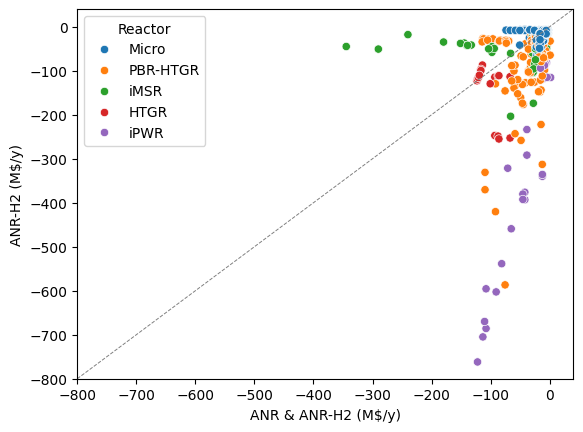

In [331]:
net_rev_comp = comparison[['FACILITY_ID', 'state', 'Reactor', 'ANR+ANR-H2 Net Ann. Rev. ($/year)','ANR-H2 Net Ann. Rev. ($/year)_tot']]
net_rev_comp['ANR & ANR-H2 (M$/y)'] = net_rev_comp['ANR+ANR-H2 Net Ann. Rev. ($/year)']/1e6
net_rev_comp['ANR-H2 (M$/y)'] = net_rev_comp['ANR-H2 Net Ann. Rev. ($/year)_tot']/1e6
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.scatterplot(ax=ax, data=net_rev_comp, x= 'ANR & ANR-H2 (M$/y)', y = 'ANR-H2 (M$/y)', hue='Reactor')
ax.set_xlim([-800,40])
ax.set_ylim([-800,40])
med_x = np.arange(-800,40,0.05)
ax.plot(med_x, med_x, color='grey', linestyle='--', linewidth=0.7)

In [332]:
positive = comparison[(comparison['ANR+ANR-H2 Net Ann. Rev. ($/year)']>0) |(comparison['ANR-H2 Net Ann. Rev. ($/year)_tot']>0)]
positive

,FACILITY_ID,state,Batch_Temp_degC_x,Highest_Temp_served_degC_x,Emissions_mmtco2/y_x,Heat_demand_MWh/hr_x,Remaining_Heat_MW_x,Remaining_temp_degC_x,Reactor,Modules,...,ANR VOM_tot,H2 VOM_tot,ANR-H2 VOM_tot,ANR-H2 Total Cost ($/year)_tot,NG Mult (MMBtu/MJ),year,NG price ($/MMBtu)_y,Avoided NG Cost_tot,H2 PTC_tot,ANR-H2 Net Ann. Rev. ($/year)_tot
606,1003490,CA,300.000000,300,0.331965,230.005464,0.0,0.0,iPWR,1,...,3.400463e+07,0.000000e+00,3.400463e+07,3.400019e+08,0.000750,2024,5.680861,3.091474e+07,1.937586e+08,-1.153286e+08
1474,1007390,CA,495.582238,600,0.276360,191.479419,0.0,0.0,PBR-HTGR,1,...,3.817690e+06,3.926962e+07,4.308731e+07,8.274078e+07,0.000779,2024,5.680861,7.343570e+06,4.268437e+07,-3.271284e+07
1475,1007390,CA,495.582238,600,0.276360,191.479419,0.0,0.0,PBR-HTGR,1,...,1.591706e+07,1.637265e+08,1.796435e+08,2.658728e+08,0.000680,2024,5.680861,2.332724e+07,1.779636e+08,-6.458197e+07
